# Introduction

In this notebook we demonstrate the use of **BM25 (Best Matching 25)** Information Retrieval technique to make trace link recovery between Use Cases and Bug Reports.

We model our study as follows:

* Each bug report title, summary and description compose a single query.
* We use each use case content as an entire document that must be returned to the query made


## Import Libraries

In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
from gensim.summarization.bm25 import BM25

import matplotlib.pyplot as plt

from sklearn.metrics import precision_recall_fscore_support, pairwise

from scipy.sparse import csr_matrix

from nltk.stem import LancasterStemmer, PorterStemmer, SnowballStemmer, WordNetLemmatizer
from nltk import word_tokenize

import datetime
import pprint
from enum import Enum

import warnings; warnings.simplefilter('ignore')

### Oracle Loader

In [19]:
class OracleLoader:
    def __init__(self, rows_names, columns_names):
        self.oracle = None
        self._columns_names = columns_names
        self._rows_names = rows_names
    
    def load(self):
        self.oracle = pd.DataFrame(columns=list(self._columns_names), 
                                   data=np.zeros(shape=(len(self._rows_names), len(self._columns_names)), 
                                                 dtype='int64'))
        self.oracle.insert(0, 'artf_name', list(self._rows_names))
        
        for index, row in trace_df.iterrows():
            idx = self.oracle[self.oracle.artf_name == row['trg_artf']].index
            self.oracle.at[idx, row['src_artf']] = row['link']

        self.oracle.set_index('artf_name', inplace=True)

## Load Dataset and Preprocessing

In [20]:
trace_df = pd.read_csv('../../data/jEdit/jEditDataset/oracle/output/trace_matrix.csv')
artfs_desc_df = pd.read_csv('../../data/jEdit/jEditDataset/oracle/output/artifacts_descriptions.csv', sep="|")

use_cases_df = artfs_desc_df[artfs_desc_df.artf_description.str.contains('Use Case ID')]
bug_reports_df = artfs_desc_df[artfs_desc_df.artf_description.str.contains('Bug Number')]

corpus = use_cases_df.artf_description
query = bug_reports_df.artf_description

use_cases_names = use_cases_df.artf_name
bug_reports_names = bug_reports_df.artf_name

orc = OracleLoader(use_cases_names, bug_reports_names)
orc.load()

# BM25 Model

#### Model Hyperparameters

In [21]:
class BM25_Model_Hyperp(Enum):
    NAME = 'bm25__name'
    K = 'bm25__k'
    B = 'bm25__b'
    EPSILON = 'bm25__epsilon'
    MIN_THRESHOLD = 'bm25__min_threshold'
    TOKENIZER = 'bm25__tokenizer'

#### Tokenizers

In [22]:
"""
Others stemmers are not relevant for our analysis:
 . RSLP Stemmer: portuguese language
 . ISRIS Stemmer: returns Arabic root for the given token 
 . Regexp Stemmer: uses regulax expressions to identify morphological affixes
 
Relevant Stemmers/Lemmatizers are implemented below. 
"""

class WordNetBased_LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(token) for token in word_tokenize(doc)]

class LancasterStemmerBased_Tokenizer(object):
    def __init__(self):
        self.stemmer = LancasterStemmer()
    def __call__(self, doc):
        return [self.stemmer.stem(token) for token in word_tokenize(doc)]

class PorterStemmerBased_Tokenizer(object):
    def __init__(self):
        self.stemmer = PorterStemmer()
    def __call__(self, doc):
        return [self.stemmer.stem(token) for token in word_tokenize(doc)]
    
class SnowballStemmerBased_Tokenizer(object):
    def __init__(self):
        self.stemmer = SnowballStemmer('english')
    def __call__(self, doc):
        return [self.stemmer.stem(token) for token in word_tokenize(doc)]

#### Quick Test with Model

In [23]:
from gensim.summarization.bm25 import BM25

corpus__ = [
     ["black", "cat", "white", "cat", "blacks"],
     ["cat", "outer", "space"],
     ["wag", "dog"],
     ['blacks']
 ]

queries = [['black'], ['cat']]

bm25__ = BM25(corpus__)

average_idf = sum(map(lambda k: float(bm25__.idf[k]), bm25__.idf.keys())) / len(bm25__.idf.keys())

result_1 = bm25__.get_scores(queries[0], average_idf=average_idf)
result_2 = bm25__.get_scores(queries[1], average_idf=average_idf)

print('result_1: {}'.format(result_1))
print('result_2: {}'.format(result_2))

result_1: [0.6192874727082551, 0, 0, 0]
result_2: [0.0, 0.0, 0, 0]


#### Model Defintion

In [24]:
"""
params_dict = {
    'bm25__k' : 1.2,
    'bm25__b' : 0.75,
    'bm25__epsilon' : 0.25,
    'bm25__name' : 'BM25',
    'bm25__tokenizer' : Tokenizer(),
    'bm25__min_threshold' : 3
}
"""
class BM25_Customized:
    # k = 1.2, b = 0.75, coord_factor = False
    def __init__(self, **kwargs):
        self.k = None
        self.b = None
        self.epsilon = None
        self.name = None
        self.tokenizer = None
        self.min_threshold = None
        self.trace_links_df = None
        
        self.set_basic_params(**kwargs)
        self.set_tokenizer(**kwargs)
    
    def recover_links(self, corpus, query, use_cases_names, bug_reports_names):
        bm25 = BM25([self.tokenizer.__call__(doc) for doc in corpus])
        average_idf = sum(map(lambda k: float(bm25.idf[k]), bm25.idf.keys())) / len(bm25.idf.keys())
        
        self.trace_links_df = pd.DataFrame(index = use_cases_names, 
                                           columns = bug_reports_names,
                                           data=np.zeros(shape=(len(use_cases_names), len(bug_reports_names)),dtype='float64'))
               
        for bug_id, bug_desc in zip(bug_reports_names, query):
            scores = bm25.get_scores(bug_desc, average_idf=average_idf)
            for idx,sc in enumerate(scores):
                self.trace_links_df.at[use_cases_names.tolist()[idx], bug_id] = sc
        
        for col in self.trace_links_df.columns:
            nlargest_df = self.trace_links_df.nlargest(n = self.min_threshold, columns=col, keep='first')    
            self.trace_links_df[col] = [1 if x in nlargest_df[col].tolist() else 0 for x in self.trace_links_df[col]]
    
    
    def set_basic_params(self, **kwargs):
        self.name = 'BM25' if BM25_Model_Hyperp.NAME.value not in kwargs.keys() else kwargs[BM25_Model_Hyperp.NAME.value]
        self.k = 1.2 if BM25_Model_Hyperp.K.value not in kwargs.keys() else kwargs[BM25_Model_Hyperp.K.value]
        self.b = 0.75 if BM25_Model_Hyperp.B.value not in kwargs.keys() else kwargs[BM25_Model_Hyperp.B.value]
        self.epsilon = 0.25 if BM25_Model_Hyperp.EPSILON.value not in kwargs.keys() else kwargs[BM25_Model_Hyperp.EPSILON.value]
        self.min_threshold = 3 if BM25_Model_Hyperp.MIN_THRESHOLD.value not in kwargs.keys() else kwargs[BM25_Model_Hyperp.MIN_THRESHOLD.value]
        
    def set_tokenizer(self, **kwargs):
        self.tokenizer = WordNetBased_LemmaTokenizer() if BM25_Model_Hyperp.TOKENIZER.value not in kwargs.keys() else kwargs[BM25_Model_Hyperp.TOKENIZER.value]
        
        #tokenizer_params = {key.split('__')[2]:kwargs[key] for key,val in kwargs.items() if '__tokenizer__' in key}
        #self.tokenizer.set_params(**tokenizer_params)
    
    def set_name(self, name):
        self.name = name
    
    def model_setup(self):
        return {"Setup" : 
                  [
                      {"Name" : self.name},
                      {"K" : self.k},
                      {"B" : self.b},
                      {"Epsilon" : self.epsilon},
                      {"Min Threshold" : self.min_threshold},
                      {"Tokenizer Type" : type(self.tokenizer)}
                  ]
               }
    
    def get_name(self):
        return self.name
    
    def get_trace_links_df(self):
        return self.trace_links_df

### Model Evaluator

In [25]:
class ModelEvaluator:
    def __init__(self, oracle, model):
        self.model = model
        self.oracle = oracle
        self.recovered_links = model.trace_links_df
        
        self.eval_df = pd.DataFrame(columns=['precision','recall','fscore','support'])
        self.mean_precision = -1
        self.mean_recall = -1
        self.mean_fscore = -1
    
    def evaluate_model(self, verbose=False, file=None):
        y_true = csr_matrix(self.oracle.values, dtype=int)
        y_pred = csr_matrix(self.recovered_links.values, dtype=int)
        
        p, r, f, sp = precision_recall_fscore_support(y_true, y_pred)

        i = 0
        for idx, row in self.oracle.iteritems():
            self.eval_df.at[idx, 'precision'] = p[i]
            self.eval_df.at[idx, 'recall'] = r[i]
            self.eval_df.at[idx, 'fscore'] = f[i]
            self.eval_df.at[idx, 'support'] = sp[i]
            i += 1
        
        self.mean_precision = self.eval_df.precision.mean()
        self.mean_recall = self.eval_df.recall.mean()
        self.mean_fscore = self.eval_df.fscore.mean()
        
        if verbose:
            self.print_report(file)
    
    def print_report(self, file=None):
        dic = self.model.model_setup()
        dic['Measures'] = {}
        dic['Measures']['Mean Precision of {}'.format(self.model.get_name())] = self.get_mean_precision()
        dic['Measures']['Mean Recall of {}'.format(self.model.get_name())] = self.get_mean_recall()
        dic['Measures']['Mean FScore of {}'.format(self.model.get_name())] = self.get_mean_fscore()
        
        if file is None:    
            pprint.pprint(dic)
        else:
            file.write(pprint.pformat(dic))
        
    def plot_precision_vs_recall(self):
        plt.figure(figsize=(6,6))
        plt.plot(self.eval_df.recall, self.eval_df.precision, 'ro', label='Precision vs Recall')

        plt.ylabel('Precision')
        plt.xlabel('Recall')

        plt.axis([0, 1.1, 0, 1.1])
        plt.title("Precision vs Recall Plot - " + self.model.get_name())
        plt.show()
    
    def save_log(self):
        print("\nSaving model log...")
        with open('../logs/' + str(datetime.datetime.now()) + '.txt', 'a') as f:
            evaluator.evaluate_model(verbose=True, file=f)
        print("Model log saved with success!")
            
    def get_mean_precision(self):
        return self.mean_precision
    
    def get_mean_recall(self):
        return self.mean_recall
    
    def get_mean_fscore(self):
        return self.mean_fscore

## Evaluate Recovering Efficiency

In order to evaluate the efficiency of the algorithm tested (LSI), we use common metrics applied in the field of IR:

    * Precision
    * Recall
    * F1-score

#### Analysis with Default Values of BM25 Model

{'Measures': {'Mean FScore of BM25': 0.0,
              'Mean Precision of BM25': 0.0,
              'Mean Recall of BM25': 0.0},
 'Setup': [{'Name': 'BM25'},
           {'K': 1.2},
           {'B': 0.75},
           {'Epsilon': 0.25},
           {'Min Threshold': 3},
           {'Tokenizer Type': <class '__main__.WordNetBased_LemmaTokenizer'>}]}


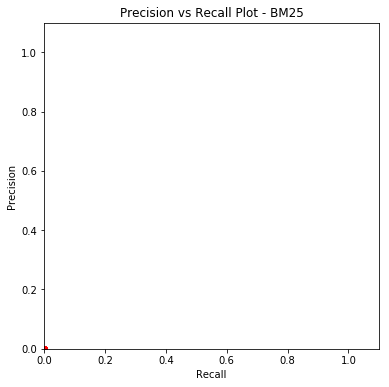

In [26]:
best_model = BM25_Customized()
best_model.recover_links(corpus, query, use_cases_names, bug_reports_names)

evaluator = ModelEvaluator(orc.oracle, best_model)
evaluator.evaluate_model(verbose=True)
evaluator.plot_precision_vs_recall()

### Function to Generate Hyperparameters

In [27]:
from itertools import product

def generate_params_comb_list(**kwargs):
    list_params = []
    for key, values in kwargs.items():
        aux_list = []
        for v in values:
            aux_list.append((key, v))
        list_params.append(aux_list)
    
    list_tuples = list(product(*list_params))
    
    list_dicts = []
    for ex_tup in list_tuples:
        dic = {}
        for in_tup in ex_tup:
            dic[in_tup[0]] = in_tup[1]
        list_dicts.append(dic)
        
    return list_dicts

### Plot Heatmap Function

In [28]:
def plot_heatmap(results_dict):
    fig_height = 2 * len(results_dict.keys())
    fig, ax = plt.subplots(figsize=(10,fig_height)) 
    df = pd.DataFrame(results_dict)
    df.set_index('model', inplace=True)       
    ax = sns.heatmap(df, vmin=0, vmax=1, linewidths=.5, cmap="Greens", annot=True, cbar=False, ax=ax)
    

### Dataframe Coloring Function

In [29]:
def highlight_df(df):
    cm = sns.light_palette("green", as_cmap=True)
    return df.style.background_gradient(cmap=cm)

### Find The Best Model

Performing model optimizations...
------------ Report -------------------

Total of Analyzed Hyperparameters Combinations: 4

Best Model and Hyperparameters Found: BM25_Cust_Model_3

{'Measures': {'Mean FScore of BM25_Cust_Model_3': 0.05952380952380952,
              'Mean Precision of BM25_Cust_Model_3': 0.047619047619047616,
              'Mean Recall of BM25_Cust_Model_3': 0.09523809523809523},
 'Setup': [{'Name': 'BM25_Cust_Model_3'},
           {'K': 1.2},
           {'B': 0.75},
           {'Epsilon': 0.25},
           {'Min Threshold': 3},
           {'Tokenizer Type': <class '__main__.SnowballStemmerBased_Tokenizer'>}]}

Plot Precision vs Recall - Best Model


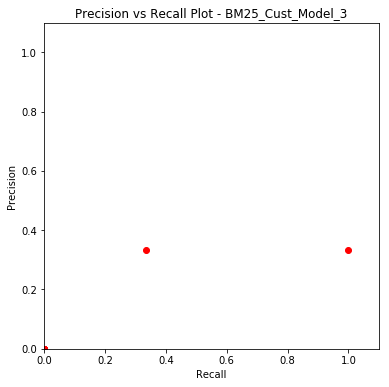


Heatmap of All Models


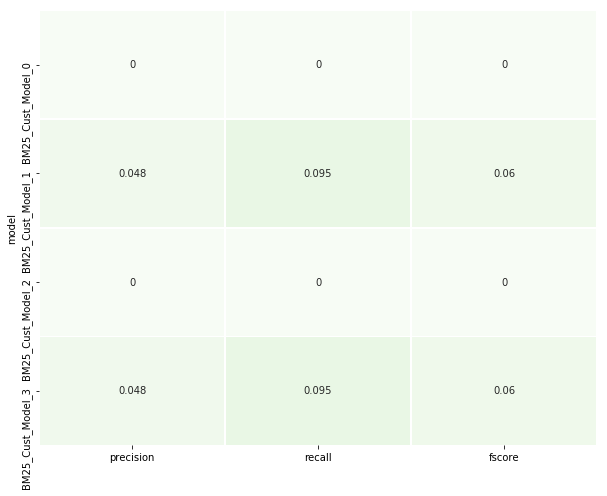

In [30]:
all_hyperparams = {
    BM25_Model_Hyperp.MIN_THRESHOLD.value : [3],
    BM25_Model_Hyperp.TOKENIZER.value : [PorterStemmerBased_Tokenizer(), LancasterStemmerBased_Tokenizer(), 
                                                   WordNetBased_LemmaTokenizer(), SnowballStemmerBased_Tokenizer()]
}

hyperparams = generate_params_comb_list(**all_hyperparams)

print('Performing model optimizations...')
best_precision = -1
best_recall = -1
best_fscore = -1
best_model = None

results = {'precision': [], 'recall': [], 'fscore': [], 'model': []}

i = 0
for hyperp in hyperparams:
    current_model = BM25_Customized(**hyperp)
    current_model.set_name('BM25_Cust_Model_{}'.format(i))
    current_model.recover_links(corpus, query, use_cases_names, bug_reports_names)
    
    evaluator = ModelEvaluator(orc.oracle, current_model)
    evaluator.evaluate_model()

    if best_recall <= evaluator.get_mean_recall():
        if best_precision <= evaluator.get_mean_precision():
            best_recall = evaluator.get_mean_recall()
            best_precision = evaluator.get_mean_precision()
            best_fscore = evaluator.get_mean_fscore()
            best_model = current_model
    
    results['precision'].append(evaluator.get_mean_precision())
    results['recall'].append(evaluator.get_mean_recall())
    results['fscore'].append(evaluator.get_mean_fscore())
    results['model'].append(current_model.get_name())
    
    i += 1

print("------------ Report -------------------\n")
print("Total of Analyzed Hyperparameters Combinations: {}".format(len(hyperparams)))

print("\nBest Model and Hyperparameters Found: {}\n".format(best_model.get_name()))            
evaluator = ModelEvaluator(orc.oracle, best_model)
evaluator.evaluate_model(verbose=True)

print("\nPlot Precision vs Recall - Best Model")
evaluator.plot_precision_vs_recall()

print("\nHeatmap of All Models")
plot_heatmap(results)

#evaluator.save_log()

### Plot Highlights

In [31]:
highlight_df(best_model.get_trace_links_df())

artf_name,BR_4020_SRC,BR_3890_SRC,BR_3844_SRC,BR_4065_SRC,BR_3880_SRC,BR_3987_SRC,BR_4067_SRC,BR_3973_SRC,BR_3898_SRC,BR_3908_SRC,BR_4058_SRC,BR_4018_SRC,BR_4005_SRC,BR_3974_SRC
artf_name,,,,,,,,,,,,,,
UC_003_TRG,1,0,1,1,1,1,1,1,1,1,1,1,1,0
UC_007_TRG,1,1,0,1,0,1,1,1,0,0,0,0,1,1
UC_010_TRG,0,0,0,0,0,0,0,0,0,0,0,0,0,0
UC_002_TRG,0,1,1,0,1,0,0,0,1,1,1,1,0,1
UC_006_TRG,0,0,0,0,0,0,0,0,0,0,0,0,0,0
UC_004_TRG,1,1,1,1,1,1,1,1,1,1,1,1,1,1
UC_005_TRG,0,0,0,0,0,0,0,0,0,0,0,0,0,0
UC_008_TRG,0,0,0,0,0,0,0,0,0,0,0,0,0,0
UC_001_TRG,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [32]:
highlight_df(orc.oracle)

,BR_4020_SRC,BR_3890_SRC,BR_3844_SRC,BR_4065_SRC,BR_3880_SRC,BR_3987_SRC,BR_4067_SRC,BR_3973_SRC,BR_3898_SRC,BR_3908_SRC,BR_4058_SRC,BR_4018_SRC,BR_4005_SRC,BR_3974_SRC
artf_name,,,,,,,,,,,,,,
UC_003_TRG,0,0,0,0,0,0,0,0,0,0,0,0,0,0
UC_007_TRG,0,0,0,0,0,0,0,0,0,0,1,0,0,0
UC_010_TRG,0,0,1,0,0,0,0,0,0,0,0,0,0,0
UC_002_TRG,0,0,0,0,1,0,0,1,0,0,0,0,0,0
UC_006_TRG,1,1,0,1,1,0,0,0,0,0,0,1,0,1
UC_004_TRG,0,0,0,0,0,1,0,0,0,0,0,0,0,0
UC_005_TRG,1,1,0,0,1,0,1,0,0,0,0,1,0,0
UC_008_TRG,0,0,0,0,0,0,0,0,0,0,0,0,1,0
UC_001_TRG,0,0,0,0,0,0,0,0,0,0,0,0,0,0
